In [1]:
import numpy as np

# Checks for the different functions of the code

## Harmonic Oscillator eigenfunctions

In [2]:
from basis_set import *
import matplotlib.pyplot as plt

In [12]:
# Normalization check (numerical integration from -L to L)
L = 100
N = 40000

x = np.linspace(-L, L, N)
Ax = 2*L/N

for n in range(10):
    norm = np.sum(HO_wf(x,n)**2)*Ax
    print("Norm of {}th eigenfunction: {:0.5f}".format(n, norm))

Norm of 0th eigenfunction: 0.99998
Norm of 1th eigenfunction: 0.99998
Norm of 2th eigenfunction: 0.99998
Norm of 3th eigenfunction: 0.99998
Norm of 4th eigenfunction: 0.99998
Norm of 5th eigenfunction: 0.99998
Norm of 6th eigenfunction: 0.99998
Norm of 7th eigenfunction: 0.99998
Norm of 8th eigenfunction: 0.99998
Norm of 9th eigenfunction: 0.99998


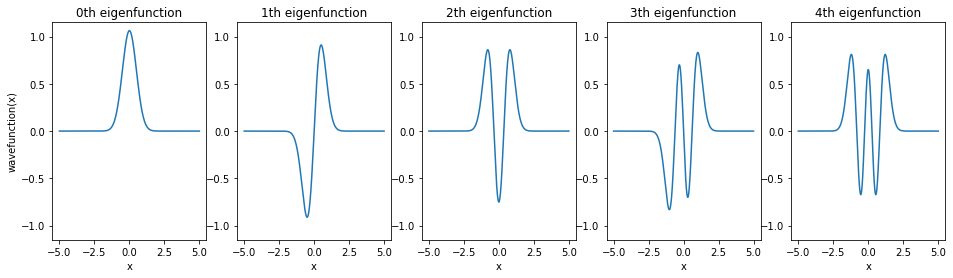

In [13]:
# Shape of the eigenfunctions
x = np.linspace(-5, 5, 1000)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[16, 4])
ax[0].set_ylabel("wavefunction(x)")
for n in range(5):
    eigenfunction = HO_wf(x,n)
    ax[n].plot(x, eigenfunction)
    ax[n].set_title("{}th eigenfunction".format(n))
    ax[n].set_ylim(-1.15, 1.15)
    ax[n].set_xlabel("x")
plt.show()

## Hartree Fock code

Here we use the two-body integrals calculated in the github link below because we just want to check that the SCF Hartree Fock works correctly. In order to do that, we calculate the energy of the Helium atom with 2 electrons and 2 single basis wave functions. 

In [7]:
class integral_master():
    """
    Calculates, stores and retrieves the values of the <pr|g|qs> integrals
    """
    def __init__(self):
        self.integral_list = None
        self.TEI          = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/two_elec_int.dat') # Load two electron integrals
        self.twoe         = {eint(row[0], row[1], row[2], row[3]) : row[4] for row in self.TEI} # Put in python dictionary
        self.ENUC = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/enuc.dat',dtype=float, delimiter=',') # ENUC = nuclear repulsion, 
        Sraw = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/s.dat',dtype=None)                    # Sraw is overlap matrix, 
        Traw = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/t.dat',dtype=None)                    # Traw is kinetic energy matrix,
        Vraw = np.genfromtxt('https://raw.githubusercontent.com/adambaskerville/adambaskerville.github.io/master/_posts/HartreeFockCode/v.dat',dtype=None)                    # Vraw is potential energy matrix

        dim = 2 # dim is the number of basis functions 
        self.S = np.zeros((dim, dim)) # Initialize integrals, and put them in a Numpy array
        self.T = np.zeros((dim, dim))
        self.V = np.zeros((dim, dim))

        for i in Sraw: self.S[i[0]-1, i[1]-1] = i[2] # Put the integrals into a matrix 
        for i in Traw: self.T[i[0]-1, i[1]-1] = i[2] # Put the integrals into a matrix
        for i in Vraw: self.V[i[0]-1, i[1]-1] = i[2] # Put the integrals into a matrix

        self.S            = symmetrise(self.S) # Flip the triangular matrix in the diagonal 
        self.V            = symmetrise(self.V) # Flip the triangular matrix in the diagonal
        self.T            = symmetrise(self.T) # Flip the triangular matrix in the diagonal
        self.Hcore        = self.T + self.V # Form core Hamiltonian matrix as sum of one electron kinetic energy, T and potential energy, V matrices
        return

    def get_1(self, p, q):
        """
        Returns the value of the h_pq integrals

        Parameters
        ----------
        p, q: int
            Indeces that specify the h_pq integral

        Returns
        -------
        float
            Value of the h_pq integral
        """

        return self.Hcore[p,q]

    def get_2(self, p, q, r, s):
        """
        Returns the value of the <pr|g|qs> integrals

        Parameters
        ----------
        p, q, r, s: int
            Indeces that specify the <pr|g|qs> integral

        Returns
        -------
        float
            Value of the <pr|g|qs> integral
        """

        p, q, r, s = p+1, q+1, r+1, s+1
        return self.twoe.get(eint(p, q, r, s), 0) 


def eint(a,b,c,d): # Return compound index given four indices using Yoshimine sort
    if a > b: ab = a*(a+1)/2 + b
    else: ab = b*(b+1)/2 + a
    if c > d: cd = c*(c+1)/2 + d
    else: cd = d*(d+1)/2 + c
    if ab > cd: abcd = ab*(ab+1)/2 + cd
    else: abcd = cd*(cd+1)/2 + ab

    return abcd

def symmetrise(Mat): # Symmetrize a matrix given a triangular one
    return Mat + Mat.T - np.diag(Mat.diagonal())

In [8]:
import numpy as np
import lib

############################################

N_electrons = 2
N_basis = 2

normalized_wf = False

max_iter_SCF = 100
eps_SCF = 1E-5

############################################

# Previous calculations to HF
integrals = integral_master()
C = np.random.rand(N_basis, N_basis)
C = np.zeros((N_basis, N_basis))
rho = lib.density_matrix(C, N_electrons)

    # Normalization of wave functions
if not normalized_wf:
    # calculate S matrix
    S = integrals.S
    SVAL, SVEC = np.linalg.eigh(S) 
    SVAL_minhalf = (np.diag(SVAL**(-0.5))) 
    X = np.dot(SVEC, np.dot(SVAL_minhalf, np.transpose(SVEC)))
else:
    S = np.eye(N_basis)

# Self Consistent Field
n_iterations = 0
rho_old = np.zeros((N_basis, N_basis))

while n_iterations < max_iter_SCF:
    n_iterations += 1

    F = lib.create_F_matrix(rho, integrals)
    
    if normalized_wf:
        E, C = np.linalg.eigh(F)
    else:
        F_prime = np.conjugate(X.transpose()) @ F @ X
        E, C_prime = np.linalg.eigh(F_prime)
        C = X @ C_prime
    
    rho = lib.density_matrix(C, N_electrons)
    total_E = lib.total_energy(rho, F, integrals)
    total_E = total_E + integrals.ENUC

    if lib.delta_rho(rho, rho_old) < eps_SCF:
        break
    
    total_E_old = total_E
    rho_old = rho

    print("E = {:0.7f} | N(SCF) = {}".format(total_E, n_iterations))

E = -3.3453739 | N(SCF) = 1
E = -2.4186182 | N(SCF) = 2
E = -2.4396214 | N(SCF) = 3
E = -2.4433698 | N(SCF) = 4
E = -2.4440162 | N(SCF) = 5
E = -2.4441272 | N(SCF) = 6
E = -2.4441462 | N(SCF) = 7


The energy for Helium obtained in the previous project is −2.8783 (atomic units) which is close to the one obtained here. The main difference is that for the Hartree Fock algorithm, we only use 2 basis functions so the result is not very close to the exact one. 